In [1]:
# import packages
!pip install mlxtend
!pip install seaborn

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from mlxtend.frequent_patterns import apriori, fpgrowth
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()

In [2]:
# set file location
#if needed please choose commented format if needed
#file_loc = Path(r'C:\Users\hruss\OneDrive\Documents\GMU\Repositories\Data_files')
file_loc = Path(r"titani.csv")

#print("file location exists:", file_loc.is_dir())
print("file location exists:", file_loc.is_file())

file location exists: True


In [3]:
# import dataset

#df = pd.read_csv("titanic.csv")
df = pd.read_csv(file_loc)
df.head()

,Unnamed: 0,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [4]:
# find out number of rows and columns

df.shape

(891, 16)

In [5]:
# find null values

nulls = df.isnull().sum()
print("These are the features with null values, and the count of null values in each.")
print(nulls[nulls >= 1])

These are the features with null values, and the count of null values in each.
age            177
embarked         2
deck           688
embark_town      2
dtype: int64


In [6]:
# Impute missing 'age' values based on another ('who') column, and check

category_means = df.groupby('who')['age'].transform('mean')
df1 = df
df1['age'].fillna(category_means, inplace=True)
df1[df1['who'] == 'child'].describe()


,Unnamed: 0,survived,pclass,age,sibsp,parch,fare
count,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000
mean,430.602410,0.590361,2.626506,6.369518,1.734940,1.265060,32.785795
std,287.079319,0.494757,0.619024,4.729063,1.638592,0.682255,33.466438
min,7.000000,0.000000,1.000000,0.420000,0.000000,0.000000,7.225000
25%,171.500000,0.000000,2.000000,2.000000,0.000000,1.000000,15.900000
50%,435.000000,1.000000,3.000000,5.000000,1.000000,1.000000,26.250000
75%,705.500000,1.000000,3.000000,9.500000,3.000000,2.000000,32.193750
max,875.000000,1.000000,3.000000,15.000000,5.000000,2.000000,211.337500


In [7]:
# try a quick association rule to see if there is some pattern to deck = NaN
# first we create a categories dataframe

df_categories = df1.drop(['pclass', 'sibsp', 'parch', 'Unnamed: 0', 'embarked', 'sex', 'age', 'fare', 'alive', 'adult_male'],axis = 1)
df_categories

,survived,class,who,deck,embark_town,alone
0,0,Third,man,NaN,Southampton,False
1,1,First,woman,C,Cherbourg,False
2,1,Third,woman,NaN,Southampton,True
3,1,First,woman,C,Southampton,False
4,0,Third,man,NaN,Southampton,True
...,...,...,...,...,...,...
886,0,Second,man,NaN,Southampton,True
887,1,First,woman,B,Southampton,True
888,0,Third,woman,NaN,Southampton,False
889,1,First,man,C,Cherbourg,True


In [8]:
# then we encode the category columns

codes = cat_encoder.fit_transform(df_categories[['class', 'who', 'deck', 'embark_town']])
names = cat_encoder.get_feature_names_out()
encoded_df = pd.DataFrame(codes.todense(), columns = names)
encoded_df

,class_First,class_Second,class_Third,who_child,who_man,who_woman,deck_A,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G,deck_nan,embark_town_Cherbourg,embark_town_Queenstown,embark_town_Southampton,embark_town_nan
0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
887,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
888,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
889,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [9]:
# then we clean things up a bit

df2 = pd.merge(encoded_df, df_categories[['survived', 'alone']], left_index=True, right_index=True)
df2['alone'].replace([0,1],[False, True], inplace=True)
df2

,class_First,class_Second,class_Third,who_child,who_man,who_woman,deck_A,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G,deck_nan,embark_town_Cherbourg,embark_town_Queenstown,embark_town_Southampton,embark_town_nan,survived,alone
0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,False
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,False
2,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1,True
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,False
4,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,True
887,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,True
888,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,False
889,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,True


In [10]:
# then we do some association rule mining using apriori and print the results

results = apriori(df2, min_support = .2, use_colnames=True)
results = results[results['itemsets'].apply(lambda x: len(x)) > 2]
results = results[results['itemsets'].apply(lambda x: 'deck_nan' in x)]
results

C:\Users\pgarc_1jof181\anaconda3\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
23,0.352413,"(deck_nan, who_man, class_Third)"
26,0.384961,"(deck_nan, embark_town_Southampton, class_Third)"
27,0.358025,"(deck_nan, alone, class_Third)"
29,0.387205,"(who_man, deck_nan, embark_town_Southampton)"
30,0.395062,"(deck_nan, alone, who_man)"
32,0.372615,"(deck_nan, alone, embark_town_Southampton)"
33,0.270483,"(who_man, deck_nan, embark_town_Southampton, c..."
34,0.289562,"(deck_nan, alone, who_man, class_Third)"
36,0.255892,"(deck_nan, alone, embark_town_Southampton, cla..."
37,0.313131,"(who_man, deck_nan, alone, embark_town_Southam..."


In [11]:
# let's look at a subset of the data we suspect is most closely related to deck = NaN
# we want to filter to: who = man, embark town = southampton, alone = true and class_third = true
# we want the resulting table to just show the counts of each variable after filtering

df2[(df2['who_man'] == True)].sum()

class_First                119.0
class_Second                99.0
class_Third                319.0
who_child                    0.0
who_man                    537.0
who_woman                    0.0
deck_A                      13.0
deck_B                      19.0
deck_C                      31.0
deck_D                      15.0
deck_E                      16.0
deck_F                       5.0
deck_G                       0.0
deck_nan                   438.0
embark_town_Cherbourg       90.0
embark_town_Queenstown      37.0
embark_town_Southampton    410.0
embark_town_nan              0.0
survived                    88.0
alone                      410.0
dtype: float64

In [12]:
# join df1 and df2 for analysis like clustering, correlation, and pca

df3 = pd.concat([df1,df2], axis=0)
df3

,Unnamed: 0,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,...,deck_C,deck_D,deck_E,deck_F,deck_G,deck_nan,embark_town_Cherbourg,embark_town_Queenstown,embark_town_Southampton,embark_town_nan
0,0.0,0,3.0,male,22.0,1.0,0.0,7.2500,S,Third,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,1,1.0,female,38.0,1.0,0.0,71.2833,C,First,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.0,1,3.0,female,26.0,0.0,0.0,7.9250,S,Third,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3.0,1,1.0,female,35.0,1.0,0.0,53.1000,S,First,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.0,0,3.0,male,35.0,0.0,0.0,8.0500,S,Third,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
887,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
888,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
889,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [13]:
# normalize age and fare, so they don't bias our clustering and correlation

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df3['age'] = scaler.fit_transform(df3[['age']])
df3['fare'] = scaler.fit_transform(df3[['fare']])
df3

,Unnamed: 0,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,...,deck_C,deck_D,deck_E,deck_F,deck_G,deck_nan,embark_town_Cherbourg,embark_town_Queenstown,embark_town_Southampton,embark_town_nan
0,0.0,0,3.0,male,0.271174,1.0,0.0,0.014151,S,Third,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,1,1.0,female,0.472229,1.0,0.0,0.139136,C,First,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.0,1,3.0,female,0.321438,0.0,0.0,0.015469,S,Third,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3.0,1,1.0,female,0.434531,1.0,0.0,0.103644,S,First,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.0,0,3.0,male,0.434531,0.0,0.0,0.015713,S,Third,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
887,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
888,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
889,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


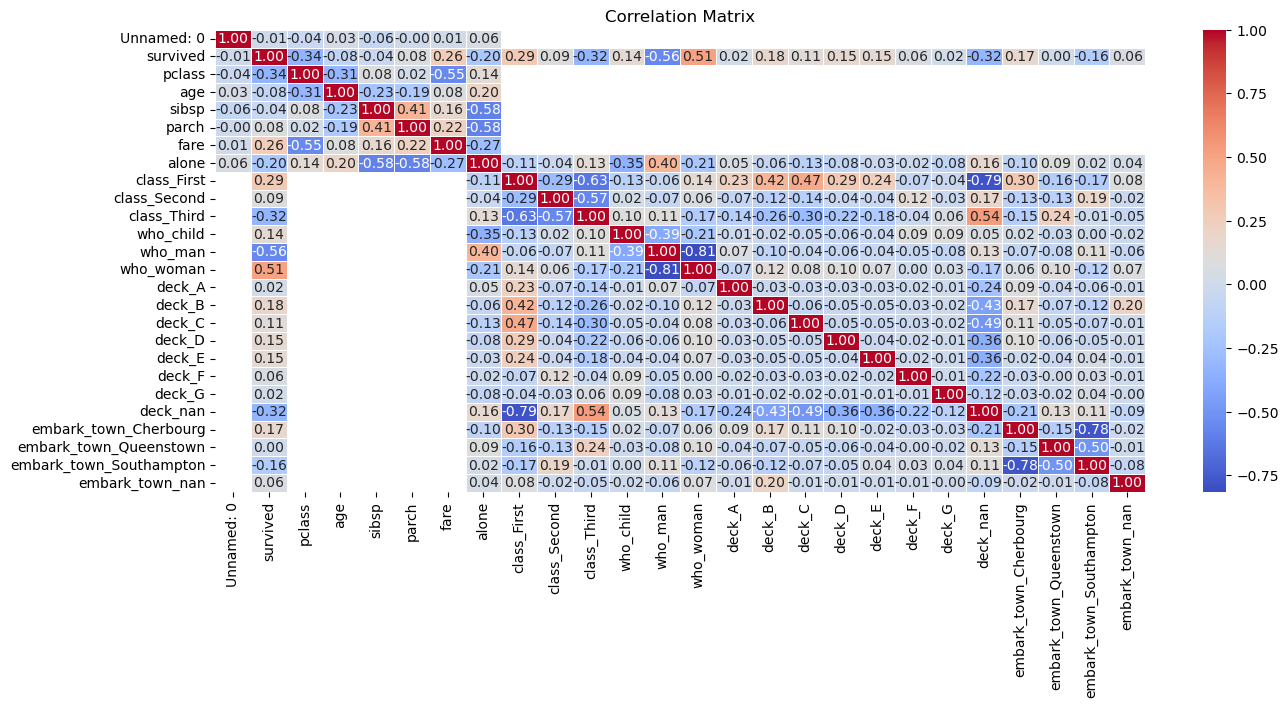

In [15]:
# discover correlations

corr_matrix = df3.corr(numeric_only=True)
plt.figure(figsize=(15, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()